In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from matplotlib.ticker import PercentFormatter
%matplotlib inline

In [2]:
df = pd.read_csv('ks-projects-201801.csv',encoding='latin-1')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
data_kick = pd.read_csv('ks-projects-201801.csv',encoding='latin-1')
data_kick = data_kick.loc[data_kick['state'].isin(
            ['successful', 'failed'])]
data_kick.dropna(inplace=True)

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(374860, 15)

In [6]:
percent_dist = round(df["state"].value_counts() / len(df["state"]) * 100,2)
percent_dist

failed        52.72
successful    35.71
canceled      10.34
live           0.75
suspended      0.49
Name: state, dtype: float64

In [7]:
df = df[df['goal'] > 100]   # Assuming that no sound project should be <$100
df = df[df['backers'] > 0]  # Assuming that no sound project should have backers == 0
df['year'] = pd.to_datetime(df['launched']).dt.year # Add year column
df['project_duration'] = pd.to_datetime(pd.to_datetime(df['deadline']) - \
                pd.to_datetime(df['launched'])).dt.day # Determine each project duration

df = df[~df['year'].isin(['1970', '2018'])] # Exclude 1970 and 2018
df['avg_backer_invest'] = df['pledged']/df['backers']


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
def percent_plot(data, title):
    
    ax = data.plot(kind='bar')
    plt.title(title)
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.show();

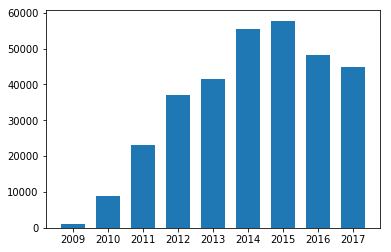

In [9]:
# Project counts by year
annual_growth = df.year.value_counts().sort_index()
index = annual_growth.index.tolist()
vals = annual_growth.tolist()

N = len(index)
ind = np.arange(N)
width = 0.7

plt.bar(ind, vals, width=width)
plt.xticks(ind, index)
plt.show()

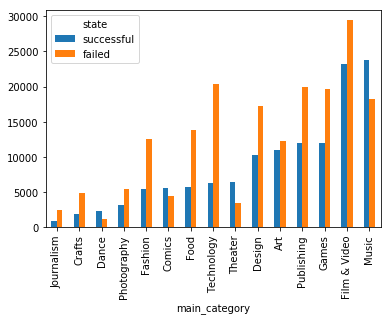

In [10]:
state_year_df = df[['main_category', 'state']]
state_year_df = state_year_df.pivot_table(index='main_category', columns='state', aggfunc=len)
state_year_df['failed'] = state_year_df['canceled'] + state_year_df['failed']+ state_year_df['suspended']
state_year_df = state_year_df[['successful', 'failed']]
state_year_df= state_year_df.sort_values('successful')
state_year_df.plot.bar()
plt.show()

In [11]:
state_year_df.sort_values('successful')

state,successful,failed
main_category,,
Journalism,971,2484
Crafts,1915,4876
Dance,2325,1135
Photography,3184,5414
Fashion,5464,12502
Comics,5617,4411
Food,5777,13883
Technology,6292,20319
Theater,6480,3445


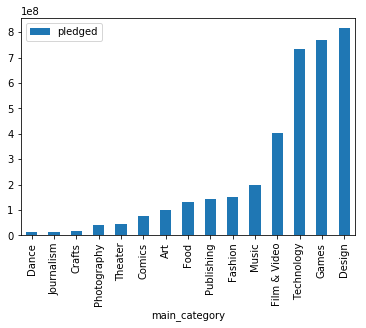

In [12]:
# Highest Pledging Categories
category_pledged_df = df[['main_category', 'pledged']].pivot_table(index='main_category', aggfunc=sum)
category_pledged_df = category_pledged_df.sort_values('pledged')
category_pledged_df.plot.bar()
plt.show()

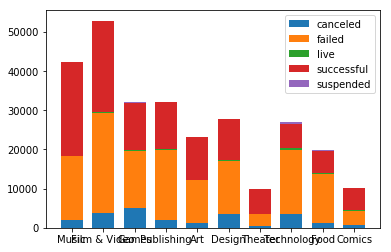

In [13]:
# Top 10 categories analysis of success and failure
subdf = df[['main_category', 'state']]
pivot = subdf.pivot_table(index='main_category', columns='state', aggfunc=len)
pivot = pivot.sort_values(by='successful', ascending=False) [:10] # Top 10 categories
attrs = pivot.index.tolist()
attr_vals = np.array(pivot.values.tolist()).T

N = len(attrs)
ind = np.arange(N)

# Stacking under each state
p1 = plt.bar(ind, attr_vals[0], width)
p2 = plt.bar(ind, attr_vals[1], width, bottom=attr_vals[0])
p3 = plt.bar(ind, attr_vals[2], width, bottom=attr_vals[0]+attr_vals[1])
p4 = plt.bar(ind, attr_vals[3], width, bottom=attr_vals[0]+attr_vals[1]+attr_vals[2])
p5 = plt.bar(ind, attr_vals[4], width, bottom=attr_vals[0]+attr_vals[1]+attr_vals[2]+attr_vals[3])

plt.legend([p1[0], p2[0], p3[0], p4[0], p5[0]], ['canceled', 'failed', 'live', 'successful', 'suspended', 'undefined'])
plt.xticks(ind, attrs)
plt.show()

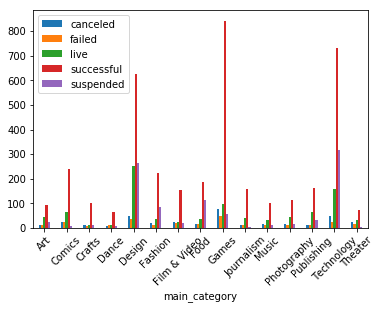

In [14]:
# Project state and Backers
backersdf = df[['main_category', 'state', 'backers']]
backers_pivot = backersdf.pivot_table(index='main_category', columns='state', aggfunc='mean')
cols = np.array(backers_pivot.columns.tolist()).T[1]
backers_pivot.plot.bar()
plt.legend(cols)
plt.xticks(rotation=45)
plt.show()

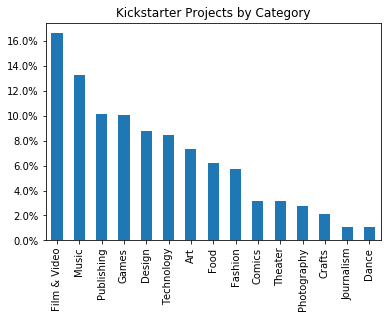

In [15]:
percent_plot((df.main_category.value_counts()/df.shape[0]*100), 
             "Kickstarter Projects by Category")

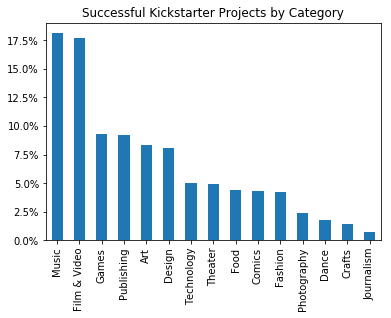

In [16]:
#categories of successful projects
percent_plot((df[df.usd_pledged_real>=df.usd_goal_real].main_category.value_counts()/
              df[df.usd_pledged_real>=df.usd_goal_real].shape[0]*100), 
              "Successful Kickstarter Projects by Category")

[Text(0, 0.5, 'USD Pledged in Million'),
 Text(0.5, 0, 'Number of Backers'),
 Text(0.5, 1.0, 'Backer vs Pledge')]

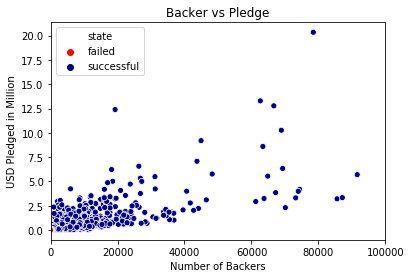

In [17]:
colors = ('red','darkblue')
ax = sns.scatterplot(x=data_kick.backers, y=data_kick.usd_pledged_real/1e6, hue=data_kick.state, palette=colors)
ax.set(ylim=(-1,None), xlim=(-1,100000))

ax.set(xlabel='Number of Backers', ylabel='USD Pledged in Million', title= 'Backer vs Pledge')

[Text(0, 0.5, 'USD Pledged in Million'),
 Text(0.5, 0, 'Pledge/Backer Ratio (funding per backer)'),
 Text(0.5, 1.0, 'Backer Ratio vs Pledge')]

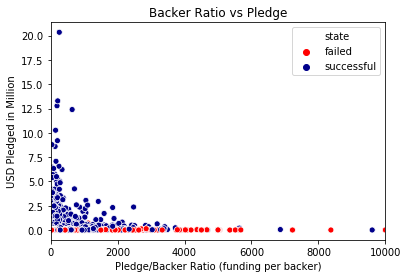

In [18]:
data_kick['backer_ratio'] = (data_kick['usd_pledged_real']//data_kick['backers']).fillna(0)
ax = sns.scatterplot(x=data_kick.backer_ratio, y=data_kick.usd_pledged_real/1e6, hue=data_kick.state, palette=colors)
ax.set(ylim=(-1,None), xlim=(-1,10000))
ax.set(xlabel='Pledge/Backer Ratio (funding per backer)', ylabel='USD Pledged in Million', title= 'Backer Ratio vs Pledge')

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


In [20]:
data = df[df['state'].isin(['successful', 'failed'])] # Just working with either successful or failed projects

X = data[['main_category', 'goal', 'pledged', 'backers']] # Selecting features from data
X = pd.get_dummies(X, columns=['main_category']) # Converting to dummies for modeling purposes
#X = X.as_matrix()
y = data['state'].as_matrix()
#y = pd.get_dummies(y).as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix



# Decision Tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Decision Tree: {}%'.format(accuracy*100))
print('F1 Score of Decision Tree: {}%'.format(f1_score(y_test, y_pred, average="macro")*100))
print('Precision Score of Decision Tree: {}%'.format(precision_score(y_test, y_pred, average="macro")*100))
print('Recall Score of Decision Tree: {}%'.format(recall_score(y_test, y_pred, average="macro")*100))
print(classification_report(y_test,y_pred))





Accuracy of Decision Tree: 99.9028553585678%
F1 Score of Decision Tree: 99.90190263132924%
Precision Score of Decision Tree: 99.90155816564052%
Recall Score of Decision Tree: 99.90224734464137%
              precision    recall  f1-score   support

      failed       1.00      1.00      1.00     63329
  successful       1.00      1.00      1.00     51963

   micro avg       1.00      1.00      1.00    115292
   macro avg       1.00      1.00      1.00    115292
weighted avg       1.00      1.00      1.00    115292



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


model = LogisticRegression(C=1)
model.fit(X_train, y_train)

log_pred=model.predict(X_test)





accuracy = accuracy_score(y_test, log_pred)
print('Accuracy of Logistic Regression: {}%'.format(accuracy*100))
print('F1 Score of Logistic Regression: {}%'.format(f1_score(y_test, log_pred, average="macro")*100))
print('Precision Score of Logistic Regression: {}%'.format(precision_score(y_test, log_pred, average="macro")*100))
print('Recall Score of Logistic Regression: {}%'.format(recall_score(y_test, log_pred, average="macro")*100))
print(classification_report(y_test,log_pred))



coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = model.coef_[0].tolist()
coefs_df['abs_coefs'] = np.abs(model.coef_[0].tolist()) #absolute value of coefficients

coefs_df = coefs_df.sort_values('abs_coefs', ascending=False).head(20)
coefs_df


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Logistic Regression: 99.9774485653818%
F1 Score of Logistic Regression: 99.97722826057733%
Precision Score of Logistic Regression: 99.97499471041951%
Recall Score of Logistic Regression: 99.97947227968228%
              precision    recall  f1-score   support

      failed       1.00      1.00      1.00     63329
  successful       1.00      1.00      1.00     51963

   micro avg       1.00      1.00      1.00    115292
   macro avg       1.00      1.00      1.00    115292
weighted avg       1.00      1.00      1.00    115292



,feature,coefs,abs_coefs
1,pledged,0.019859,0.019859
0,goal,-0.018876,0.018876
2,backers,0.003666,0.003666
13,main_category_Music,0.000044,0.000044
9,main_category_Film & Video,0.000042,0.000042
3,main_category_Art,0.000025,0.000025
15,main_category_Publishing,0.000020,0.000020
17,main_category_Theater,0.000018,0.000018
8,main_category_Fashion,0.000006,0.000006
4,main_category_Comics,0.000006,0.000006


In [24]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train , y_train)

GNB_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, GNB_pred)
print('Accuracy of Logistic Regression: {}%'.format(accuracy*100))
print('F1 Score of Logistic Regression: {}%'.format(f1_score(y_test, GNB_pred, average="macro")*100))
print('Precision Score of Logistic Regression: {}%'.format(precision_score(y_test, GNB_pred, average="macro")*100))
print('Recall Score of Logistic Regression: {}%'.format(recall_score(y_test, GNB_pred, average="macro")*100))
print(classification_report(y_test,GNB_pred))





Accuracy of Logistic Regression: 67.00985324220241%
F1 Score of Logistic Regression: 60.249789516039144%
Precision Score of Logistic Regression: 78.41507968826494%
Recall Score of Logistic Regression: 63.562104965333035%
              precision    recall  f1-score   support

      failed       0.63      0.99      0.77     63329
  successful       0.94      0.29      0.44     51963

   micro avg       0.67      0.67      0.67    115292
   macro avg       0.78      0.64      0.60    115292
weighted avg       0.77      0.67      0.62    115292



In [25]:
from sklearn.neighbors import KNeighborsClassifier
#making the instance
kmodel = KNeighborsClassifier(n_jobs=-1)
#learning
kmodel.fit(X_train,y_train)
#KNN Accuracy Prediction
KNN_pred=kmodel.predict(X_test)


accuracy = accuracy_score(y_test, KNN_pred)
print('Accuracy of Logistic Regression: {}%'.format(accuracy*100))
print('F1 Score of Logistic Regression: {}%'.format(f1_score(y_test, GNB_pred, average="macro")*100))
print('Precision Score of Logistic Regression: {}%'.format(precision_score(y_test, GNB_pred, average="macro")*100))
print('Recall Score of Logistic Regression: {}%'.format(recall_score(y_test, GNB_pred, average="macro")*100))
print(classification_report(y_test,GNB_pred))






Accuracy of Logistic Regression: 99.95836658224336%
F1 Score of Logistic Regression: 60.249789516039144%
Precision Score of Logistic Regression: 78.41507968826494%
Recall Score of Logistic Regression: 63.562104965333035%
              precision    recall  f1-score   support

      failed       0.63      0.99      0.77     63329
  successful       0.94      0.29      0.44     51963

   micro avg       0.67      0.67      0.67    115292
   macro avg       0.78      0.64      0.60    115292
weighted avg       0.77      0.67      0.62    115292

